# Predicting World of Warcraft Avatar Leveling behavior
This project utilizes the publicly available World of Warcraft Avatar History dataset to garner insight into the game itself as well as its player base. In this case, I have focused on one particular problem: the leveling behavior of avatars.

## Problem
Can we predict whether or not an avatar on World of Warcraft will be leveled to the max based upon simple metrics describing play behavior? In particular, we would like to explore whether avatar location and guild preferences, as well as play behavior, can be used to predeict whether or not an avatar will reach the maximum level allowable in WoW.

## Data
This dataset represents one year of observations in 2008 for ~30,000 avatars in WoW. These observations include the level, location, guild, race, and class of each avatar at a given instance in time. Our goal here is to explore this data for any interesting relationships with our main problem in mind. Ideally, we would like to be able to boil down this raw dataset to a few useful metrics that correlate with whether or not an avatar reaches max level.

In [69]:
import pandas as pd
#We don't like infinities, so set those to null
pd.set_option('mode.use_inf_as_null', True)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cPickle

#Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import precision_recall_fscore_support

from functions import plot_learning_curve, distill_wowah

#Constants
#Max level before WLK
MAX_LEVEL1 = 70
#Max level after
MAX_LEVEL2 = 80
#Release of the Wrath of the Lich King expansion
WLK_RD = pd.to_datetime('11/18/2008')

# Load and wrangle data

In [70]:
#Load data
wow_df = pd.read_csv('wowah_data.csv')

Get some basic info from the data

In [71]:
wow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
char          int64
 level        int64
 race         object
 charclass    object
 zone         object
 guild        int64
 timestamp    object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


And some basic stats

In [72]:
wow_df.columns.values

array(['char', ' level', ' race', ' charclass', ' zone', ' guild',
       ' timestamp'], dtype=object)

In [73]:
#Note that some column names have added whitespace. Strip that whitespace for clarity
for c in wow_df.columns:
    c = c.lstrip()
    
wow_df.columns = [x.lstrip() for x in wow_df.columns.values]    

#Verify it worked
wow_df.columns.values

array(['char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp'], dtype=object)

In [74]:
#Having all the unique character names will be useful later
chars = np.sort(wow_df.char.unique())
nav = np.size(chars)
#Calculate the average number of data points per avatar
print(10826733 / nav)

#Also, let's find the number of unique guilds
guilds = np.sort(wow_df.guild.unique())
ng = np.size(guilds)

#Also, let's find the number of unique locations
locs = np.sort(wow_df.zone.unique())
nl = np.size(locs)

289


So we have ~300 data points per avatar. Now let's explore the properties of the time sampling. For this, we need to convert the timestamp column to a numerical value. 

In [105]:
#Now let's convert the timestamp column to numerical values
#First check if it's already been done
try:
    with open('timestamps.pkl', 'rb') as f:
        #Use cPickle for past serialization
        dts = cPickle.load(f)
except IOError:
    dts = pd.to_datetime(wow_df['timestamp'])

    with open('timestamps.pkl', 'wb') as f:
        cPickle.dump(dts, f)
        
#Just replace old timestamp column since it's no longer necessary 
wow_df['timestamp'] = dts

Let's try plotting a level curve for one player to examine how they progressed.

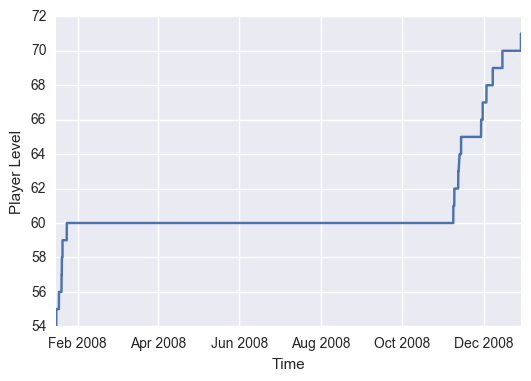

In [77]:
av = wow_df.loc[wow_df['char'] == chars[1]]

#Find where max level is reached since curve is pretty boring after that
prog = av[av['level'] < MAX_LEVEL2]

plt.plot(prog['timestamp'], prog['level'])
plt.xticks(['02-2008', '04-2008', '06-2008', '08-2008', '10-2008', '12-2008'], 
           ['Feb 2008', 'Apr 2008', 'Jun 2008', 'Aug 2008', 'Oct 2008', 'Dec 2008'])
plt.xlabel('Time')
plt.ylabel('Player Level')

It looks like this avatar was level ~54 when the observations began, and progressed to close to the max level in about a year with a long hiatus. This hiatus corresponds to the original WoW level cap, and the progression from this level begins when Wrath of the Lich King was released. It's also clear that the expansion release during this timeframe will need to be properly accounted for in order to make accurate predictions. 

# Distilling the data on an avatar-by-avatar basis
Since we are looking for variations in level progression across a broad range of levels and times, we want to come up with some features that describe the progression of level and play over time. So, let's go through each avatar and see if it reached max level. We will also create a new dataframe called av_df to store other potantially useful metrics for each avatar. These will include such things as average level, max level, level range, whether or not the avatar changed guilds at all, most frequented guild, and most frequented location.

At the end of the day, we want to characterize the variations in avatar level and see if these variations can help us predict whether each avatar reached the max level or not.

In [78]:
#Use a function to distill raw WoWAH data into quantities grouped by character ID. This script essentially 
# uses the pandas groupby and agg functions to calculate metrics for each character over the time baseline
av_df = distill_wowah(wow_df, chars)
av_df.info()

So now we have a new dataframe that contains one row per avatar with some aggregate properties for each. We now want to clean the data up. As other explorations of this data have shown, there are some problematic avatars. First, a significant fraction of them logged on for only one play. Given that we want to explore time evolution with this dataset, singly observed avatars will not tell us much. Thus, we want to get rid of these. Additionally, many avatars show mysterious race/class swaps even though these data predate race swapping in WoW. It is unclear whether these race and class swaps are real, or whether they reflect inconsistencies in the data. In any case, such swaps will likely muddy the waters for some insights to gain in terms of race/class dependencies, so we will also remove all characters which show more than one race or class.

In [106]:
#Remove singly observed avatars
av_df = av_df[av_df['nplays'] > 1]
#Remove race changing avatars
av_df = av_df[av_df['nrace'] == 1]
#Remove class changing avatars
av_df = av_df[av_df['ncharclass'] == 1]

print(len(av_df))

27574


So there were almost 10,000 problematic avatars. That effectively reduces our dataset by 1/3. Still, we should still be able to look for interesting relationships with this cleaned dataset.

# Race and class
Now let's see if there are any trends in terms of max leveling with race or class. Each race and class has its unqiue abilities which we expect should affect the level progression of avatars. Let us explore the existence of these correlations with some plots. The following plots will show the fraction of avatars in a given class-race combination that reached max level (level 80).

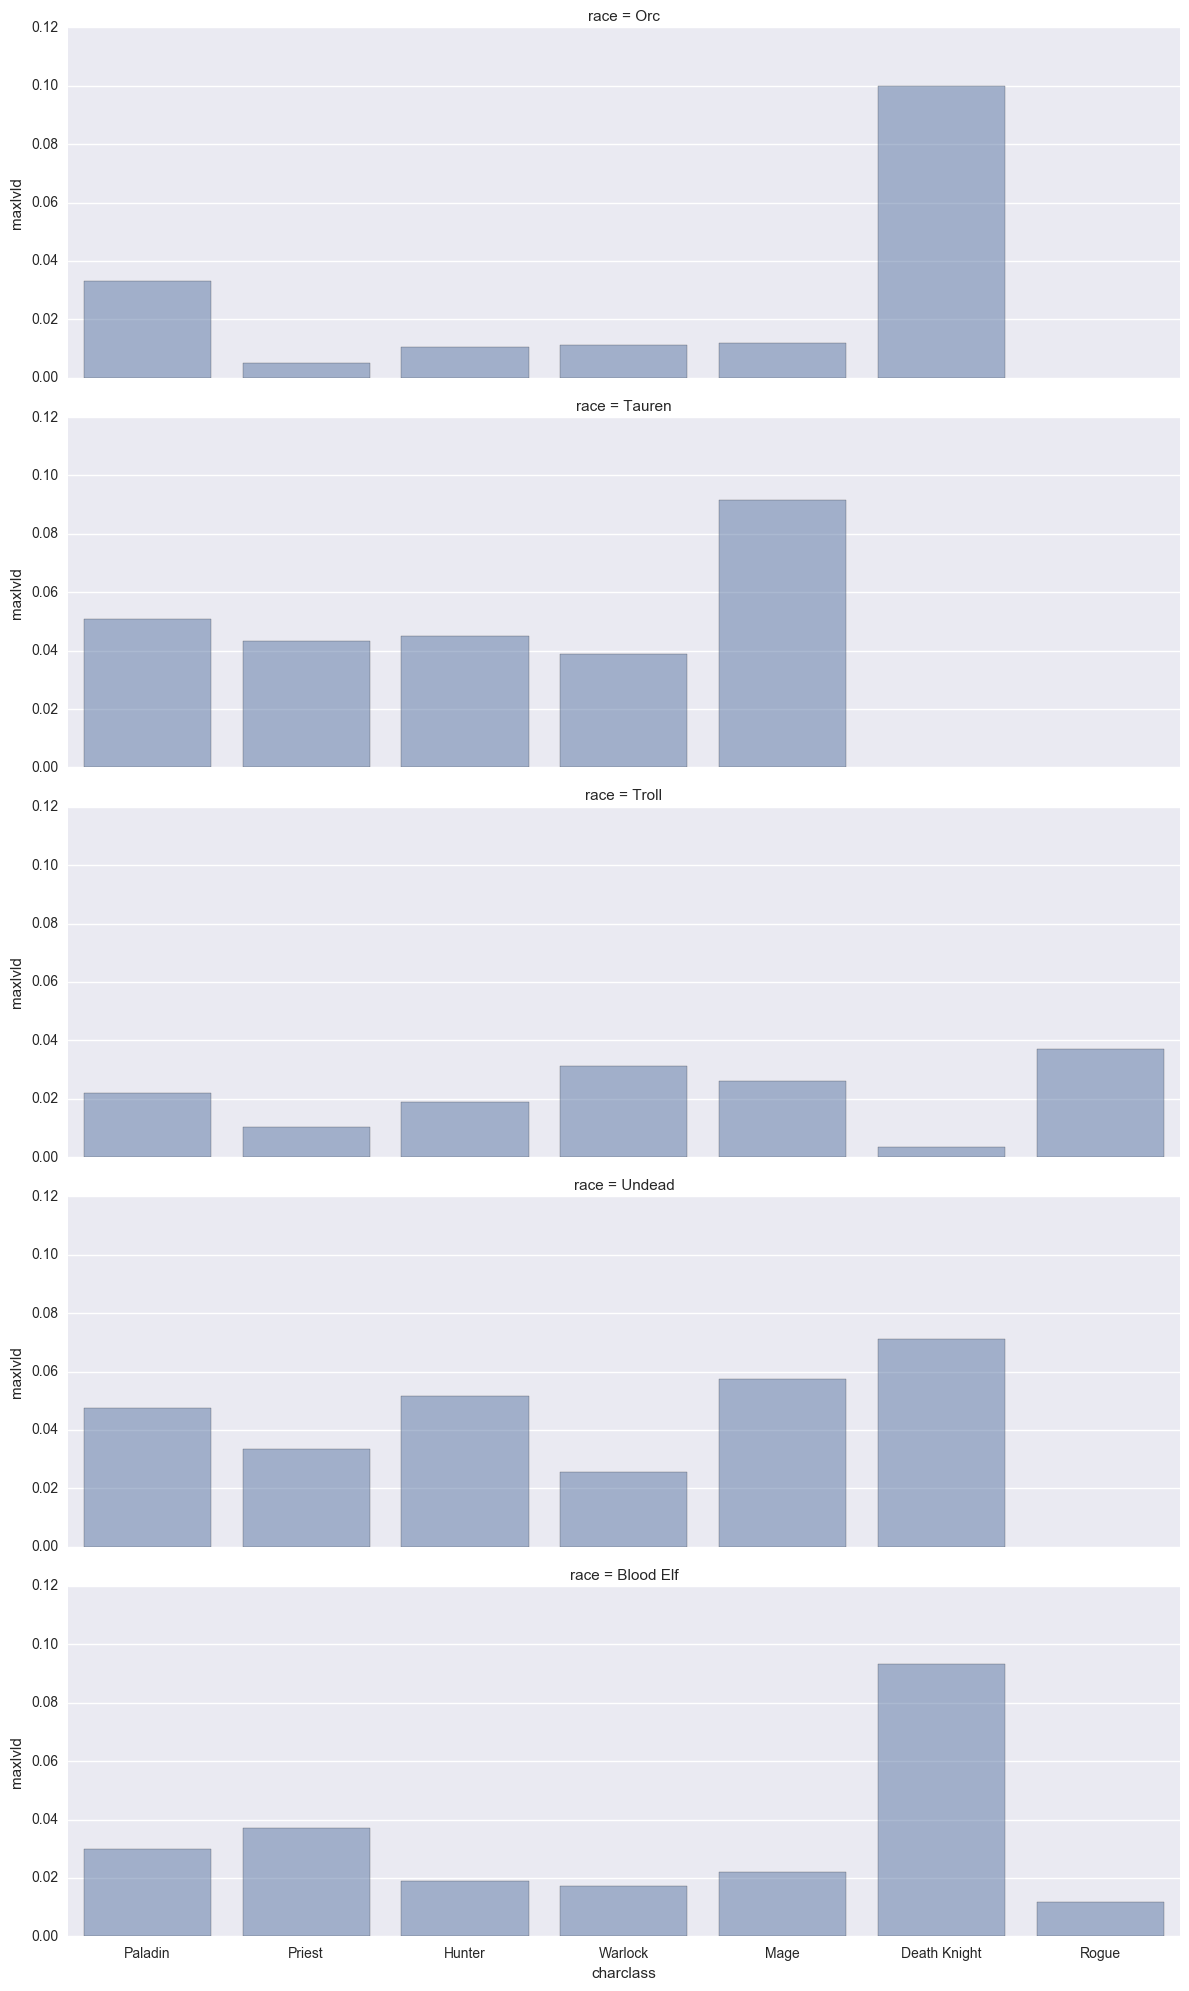

In [81]:
grid = sns.FacetGrid(av_df, row='race', size=4, aspect=3)
grid.map(sns.barplot, 'charclass','maxlvld', alpha=.5, ci=None)

So it does indeed look like whether or not an avatar reached max level depends on both the race and class. Death Knights particularly appear to prefer reaching max level across race lines. This probably reflects the fact that the Wrath of the Lich King was released during this dataset, and thus this class had the 'new' factor causing many players to level their first Death Knight. We also see race specific preferences, such as the Troll Rogue, Tauren Mage, and Orc Paladin. In any case, both race and class will probably be useful 

# Amount of play
Does the amount of time and number of times played correlate with whether or not an avatar reaches max level? We might intuitively expect it to, but let's check it out in detail with some plots.

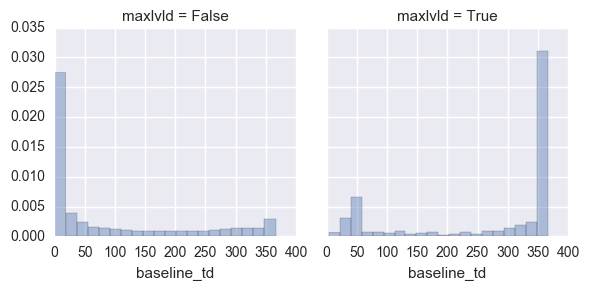

In [82]:
# We might expect the frequency of max leveling to increase with both time baseline and number of plays, 
# which are both measures of amount of gameplay.
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'baseline_td', bins=20, kde=False, norm_hist=True)

As expected, the total time baseline for play correlates strongly with whether or not an avatar achieved max level. Aside from the simple intuitive correlation, we also observe a secondary peak in max-leveled avatars with time baselines of ~30-40 days attributable to the expansion release. Clearly, the total time played should factor into our model.

Now let's see if similar relationships hold for the number of plays.

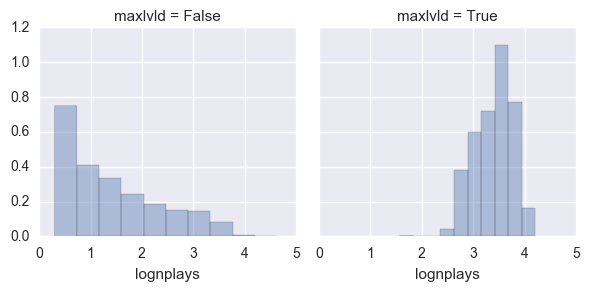

In [83]:
#Make nplays log scaled given the huge range
av_df['lognplays'] = np.log10(av_df['nplays'])
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'lognplays', bins=10, kde=False, norm_hist=True)

We again see quite different nplay distributions for avatars who reached max level compared with those who don't. Specifically, the max-leveled avatars were played on average a few thousand times. On the other hand, the non-max leveled avatars were played significantly less than 1000 times. 

## Play rate
We can combine the above two features and calculate an average 'rate' of play. Essentially, we will divide the number of plays by the total time baseline. This will give us an idea how frequently each avatar was played. We expect that the play rate is correlated with max leveling given that it combines two other correlated features.

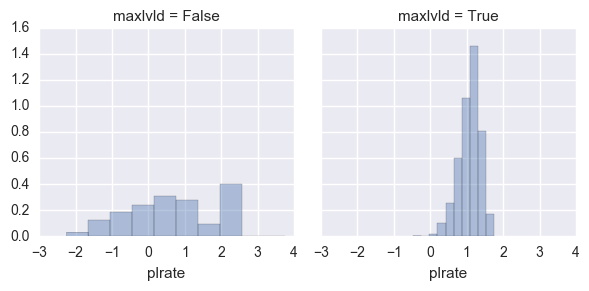

In [84]:
#Construct play rate
av_df['plrate'] = np.log10(av_df['nplays'] / av_df['baseline_td'])

g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'plrate', bins=10, kde=False, norm_hist=True)

It appears that our intuition was correct. The distributions of max leveling appear starkly different between the two sets of avatars. Avatars that reached max level (post WLK) exhibit a somewhat lognormal distribution peaking at around 10 plays/day. In contrast, the non-max-leveled avatars illustrate a much broader distribution with less frequent play rates on average. The exception is the lonesome peak at play rates >100/day. This would seem to represent avatars that started to level quickly after WLK was released, but did not succeed before these observations ended.

## Progression rate
Now we will construct another feature: prate = lvlrng / baseline, a crude estimator for the rate of progression. Essentially, this measures on average the rate of leveling per day for each avatar. Note however that we cannot simply take the average over the whole baseline. This is because progression becomes impossible at max level. Thus, if an avatar spent a significant amount of time at max level, this ratio will be artificially low. So, we need to only consider the time baseline BEFORE max level was reached.

First, to get a feel of the individual features making up prate, let's plot their maxlvld distributions.

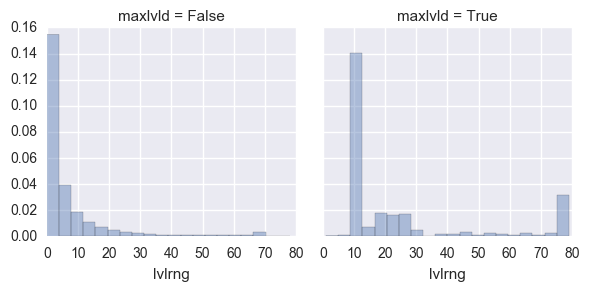

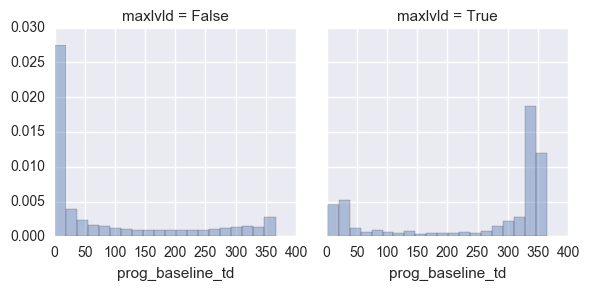

In [85]:
#Level range
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'lvlrng', bins=20, kde=False, norm_hist=True)

#Progression baseline
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'prog_baseline_td', bins=20, kde=False, norm_hist=True)

/Users/two-liter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


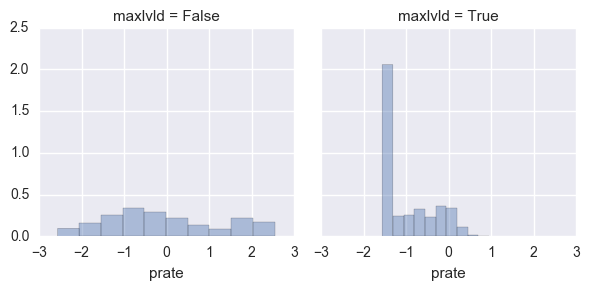

In [86]:
#Construct progression rate
av_df['prate'] = np.log10(av_df['lvlrng'] / av_df['prog_baseline_td'])
#So pandas seems to be unable to properly handle NANs, so I am just going to drop rows with prate=NaN
av_df_npr = av_df[np.isfinite(av_df['prate'])]
g = sns.FacetGrid(av_df_npr, col='maxlvld')
g.map(sns.distplot, 'prate', bins=10, kde=False, norm_hist=True)

The bottom plot, perhaps unsurprisingly, strongly resembles the similar one using the full baseline of observations for a character. This indicates a strong correlation between total time played and time spent leveling, which implies that most avatars are played to progress leveling. Both features show different distributions for avatars that reached max level, and those that didn't. 

Let us now consider the combination of these features, prate.

Again by combining the two features decribing the avatar level progression, we obtain a new feature correlated with max leveling. Thus, we conclude to include this feature in our final model.

# Guild
## Does the guild affect the likelihood of max leveling?
Another feature we would like to explore is the guild behavior the avatar. Its relation to max leveling may not be as initially straightforward as other features, but different cultures and membership of different guilds may certainly affect the likelihood that its constituent avatars reach max level. Note that an avatar can have been in multiple guilds throughout these observations, so we are forced to deal with some summary statistics. Namely, the number of guilds an avatar was in and the guild it was observed in most frequently. First, we examine the former.

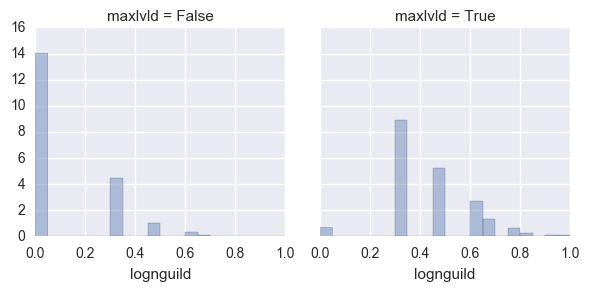

In [87]:
#Number of guilds
av_df['lognguild'] = np.log10(av_df['nguild'])
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'lognguild', bins=20, kde=False, norm_hist=True)

There does appear to be some differnce in the number of guilds occupied between the two sets of avatars. The main difference is the overwhelming peak at 1/no guild for avatars that did not reach max level. 

Let's also explore how the guild rate, or number of guilds averaged over the time baseline, affects the max leveling.

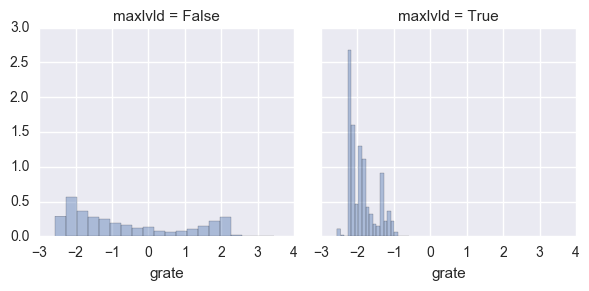

In [88]:
#Number of guilds per unit time
av_df['grate'] = np.log10(av_df['nguild'] / av_df['baseline_td'])
g = sns.FacetGrid(av_df.loc[np.isfinite(av_df['grate'])], col='maxlvld')
g.map(sns.distplot, 'grate', bins=20, kde=False, norm_hist=True)

It appears that those avatars who fluctuate between guilds less rapidly achieve max level more frequently than those who float back and forth between many guilds quickly. Apparently, loyalty to a guild correlates with leveling. The stark difference between the two distributions indicates that this will likely be an important feature to consider in our model.

We will now investigate whether or not specific guilds promote max leveling more than others.

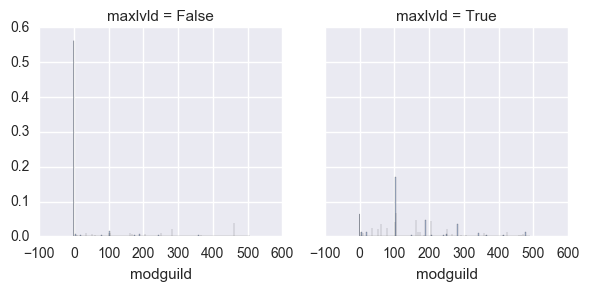

In [89]:
#Most frequented guild
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'modguild', bins=ng, kde=False, norm_hist=True)

In line with out initial assumption, different guilds tend to promote max leveling more. There also appears to be one guild that tends to disfavor max leveling significantly more than the others. Finally, an avatar is overwhelmingly less likely to reach max level if it did not belong to a guild (strong peak at -1). Thus, the social aspect of guilds is an immensely important one to WoW, and we should try to include occupied guild in our model.

# Location
Finally, let us explore another categorical feature on whether or not an avatar reached max level: locations frequented. First, we take a look at the number of locations frequented by avatars from the two sets.

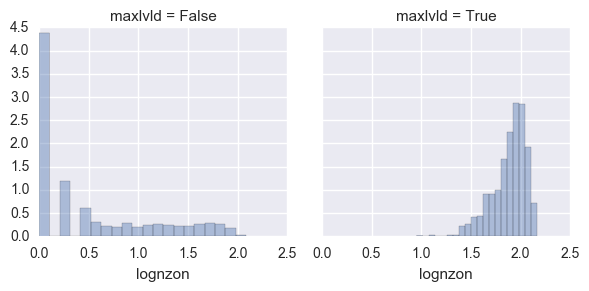

In [90]:
av_df['lognzon'] = np.log10(av_df['nzon'])
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'lognzon', bins=20, kde=False, norm_hist=True)

Again we see a pretty strong correlation in maxlvld with the number of unique zones visited. Clearly most avatars who only visited one unique location didn't seem to level much. On the other hand, those that did achive max level on average visited over an order of magnitude more unique locations. This may simply be reflecting the fact that as more time is spent playing, an avatar is more likely to visit new locations.

As with the guilds, it may be important to factor in how many locations an avatar vists in a timespan. Thus, we will create a location rate feature, which measures how frequently an avatar moves between different locations. 

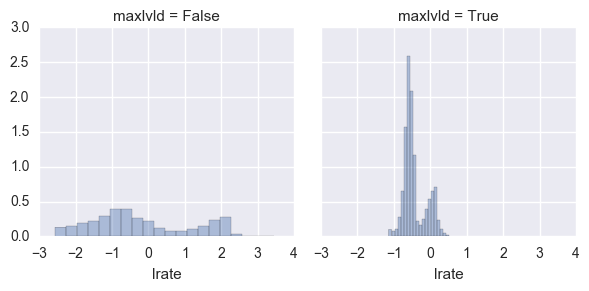

In [91]:
#Number of locations per unit time
av_df['lrate'] = np.log10(av_df['nzon'] / av_df['baseline_td'])
g = sns.FacetGrid(av_df.loc[np.isfinite(av_df['lrate'])], col='maxlvld')
g.map(sns.distplot, 'lrate', bins=20, kde=False, norm_hist=True)

Again, we see that when we control for the time baseline of observations, the location change rate correlates fairly strongly with max leveling.

As with specific guilds, we now want to see if specific locations visited tend to correlate more strongly with leveling to the max.

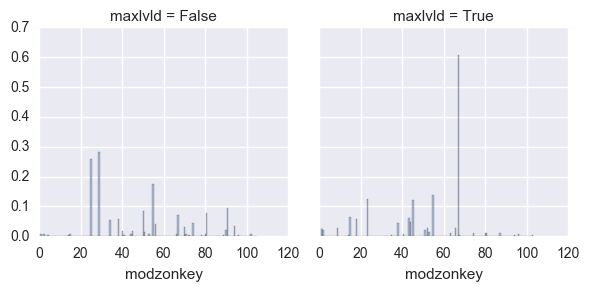

In [92]:
#Most frequented location
#For this, we need to convert the categorical modzon feature to a numerical one
#Use get_dummies for this
av_df_dum = pd.get_dummies(av_df['modzon'] , columns=['modzon'])

av_df['modzonkey'] = av_df_dum.values.argmax(1)

g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'modzonkey', bins=nl, kde=False, norm_hist=True)

Finally, we do again see clear indications that visiting certain locations is strongly correlated with reaching max level. Certain locations contain quests, beasts, other game features that cater more towards certain level bands. Thus, we will want to include modzon in the features for the final model.

# Fit model to predict whether avatars max leveled or not

In [93]:
#First, we need to convert the categorical variables to dummy variables for compatibility with standard algorithms
#pandas has the get_dummies function which does just this
#Make dummy variables
av_df_dum = pd.get_dummies(av_df, columns=['race', 'charclass', 'modzon', 'modguild'])

#Get rid of NaN rates
av_df_dum = av_df_dum.loc[(np.isfinite(av_df_dum['plrate'])) & (np.isfinite(av_df_dum['prate']))]
#We also want to get ridof many features. We want to remove all features that are cumulative over the time coverage 
# because the model loses its predictive power if it needs to know all these details over the specific time baseline
#We also remove the number of races and classes, since these have been cleaned to all be identically 1
X = av_df_dum.drop(['nrace', 'ncharclass', 'char', 'lastplay', 'firstplay', 'baseline', 'prog_baseline', 
                    'nzon', 'nguild', 'baseline_td', 'prog_baseline_td', 'nplays', 'lvlrng', 
                    'lognzon', 'lognguild', 'lognplays', 'maxlvl',
                    'maxlvld', 'maxlvld_preWLK'
                    ], axis=1).copy()
X['preWLK'] = X['preWLK'].astype(int)
X['postWLK'] = X['postWLK'].astype(int)
y = av_df_dum['maxlvld']

#Next, split dataset up into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Thus, we are left with race, class, and most frequented guilds and locations as features for the model. Additionally, we include whether or not an avatar was created before or after the WLK expansion since this obviosuly has a huge bearing on the max level. Finally, we include only time baseline-independent numerical features: the average level and the play, progression, guild, and location rates. We do not want our model dependent upon how long an avatar has been observed for in order to increase the generality of the model.

Now we fit a logistic regression model to the avatar data. Such a model produces an average classfication accuracy of ~98.4%. 

In [94]:
#Fit a logistic regression model to the maxlvld data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

98.37

We can also see which features correlate most and least strongly with max leveling. The following table displays features and their correlations with max leveling. 

In [95]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
4,prate,2.254899
6,lrate,2.071836
66,modzon_Icecrown,1.504168
110,modzon_The Storm Peaks,1.404638
126,modzon_Zul'Drak,0.885220
311,modguild_291,0.797298
117,modzon_Undercity,0.696083
91,modzon_Sholazar Basin,0.661607
114,modzon_Tirisfal Glades,0.660597
57,modzon_Ghostlands,0.622398


# Evaluating the model

So evidently, this model works pretty well. It has extremely high scores when predicting max leveling on the test set. Some interesting things to note. 

1) The top few rows show the features most correlated with max leveling. Most of the most strongly correlated features are locations and guilds. Aside from those, we see the play rate, progression rate, and location rate to all be important factors in determining whether one of these avatars reaches max level or not.

2) On the other side of things, we see certain locations strongly correlated with not acheiving max level. Few guilds are negatively correlated with max leveling.

3) The pre and post-WLK flags are the strongest anti-correlated with max leveling. 

But wait... is this score too good to be true? Let's investigate for possible overfitting using learning curves.

<module 'matplotlib.pyplot' from '/Users/two-liter/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

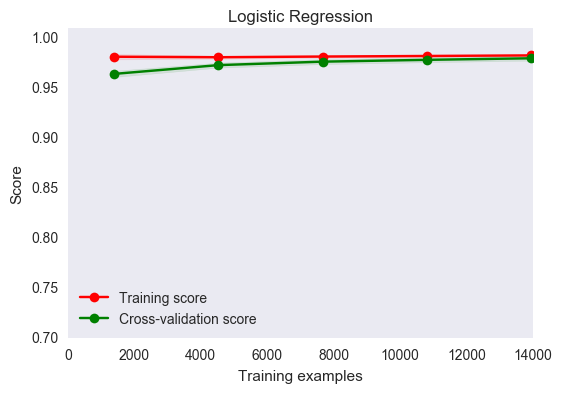

In [96]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(LogisticRegression(), 'Logistic Regression', X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

This learning curve shows that the model is being pretty well fit for both the training and cross-validation sets. The fact that it does equally as well on the CV set indicates that overfitting may actually not be a problem.

Let's also examine the precision and recall of the model.

In [97]:
pr, rec, fsc, sup = precision_recall_fscore_support(y_test, y_pred, average=None)
print(pr)
print(rec)

[ 0.98800959  0.75      ]
[ 0.98860228  0.74025974]


It also appears that the model is quite precise and recalls accurately when an avatar did not reach max level. However, it appears less precise when predicitng max leveling, and recalls those avatars even worse (although in all cases, >3/4 of the labels are correclty recalled). So, this model is okay, but maybe we can do better. Or perhaps our machine learning algorithm isn't the best. Let's try another one.

In [98]:
#Do the same with Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

100.0

<module 'matplotlib.pyplot' from '/Users/two-liter/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

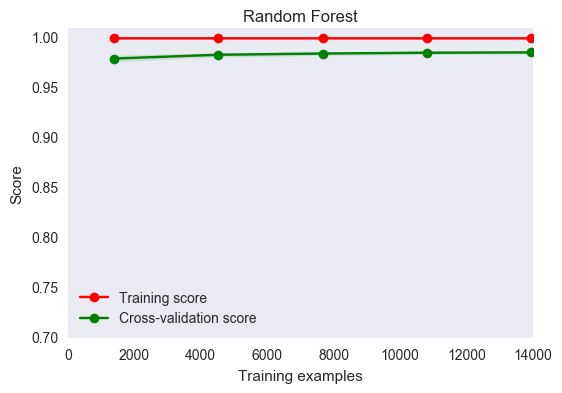

In [99]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(RandomForestClassifier(n_estimators=100), 'Random Forest', X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [100]:
pr, rec, fsc, sup = precision_recall_fscore_support(y_test, y_pred, average=None)
print(pr)
print(rec)

[ 0.98723278  0.925     ]
[ 0.99730054  0.72077922]


So, random forest performs better than logistic regression in this case. However, we do see the CV learning curve to be systematically less accurate than that of the training set. This indicates that the model might be overfitting the data and that we need more training data for this model. The recall using this classifier also performs similarly to logistic regression. Thus, we conclude that RF may not be the best algorithm in this case unless more data can be added, and we'll stick with logistic regression for now. 

# Removing Wrath of the Lich King
Evidently, our chosen model performs poorly in terms of precisely and accurately recalling whether avatars reached max level or not. Thus, maybe we need to tweak our model. In particular, it is likely that the effects of WLK on this dataset are discontinuous in time, and thus are probably mucking up things. Therefore, we will try the above again using only pre-WLK avatars. 

In [101]:
#Recalculate progression metrics restricting to pre-WLK
#In this case, we will just reconstruct the avatar dataframe using only observations from the original wow_df pre-WLK
wow_df = wow_df.loc[wow_df['timestamp'] < WLK_RD]

#Now re-distill using only pre-WLK data
av_prewlk_df = distill_wowah(wow_df, chars)

#Now calculate rates
#Number of guilds per unit time
av_prewlk_df['grate'] = np.log10(av_prewlk_df['nguild'] / av_prewlk_df['baseline_td'])
#Number of locations per unit time
av_prewlk_df['lrate'] = np.log10(av_prewlk_df['nzon'] / av_prewlk_df['baseline_td'])
#Construct play rate
av_prewlk_df['plrate'] = np.log10(av_prewlk_df['nplays'] / av_prewlk_df['baseline_td'])
#Construct progression rate
av_prewlk_df['prate'] = np.log10(av_prewlk_df['lvlrng'] / av_prewlk_df['prog_baseline_td'])

#Make dummy variables
av_df_dum = pd.get_dummies(av_prewlk_df, columns=['race', 'charclass', 'modzon', 'modguild'])

#Next, split dataset up into training and test set
#Get rid of NaN rates and post-WLK avatars
av_df_dum = av_df_dum.loc[(np.isfinite(av_df_dum['plrate'])) & (np.isfinite(av_df_dum['prate']))]
#We also want to get ridof many features. We want to remove all features that are cumulative over the time coverage 
# because the model loses its predictive power if it needs to know all these details over the specific time baseline
#We also remove the number of races and classes, since these have been cleaned to all be identically 1
X = av_df_dum.drop(['nrace', 'ncharclass', 'char', 'lastplay', 'firstplay', 'baseline', 'prog_baseline', 
                    'nzon', 'nguild', 'baseline_td', 'prog_baseline_td', 'nplays', 'lvlrng', 
                    'maxlvl',
                    'maxlvld', 'maxlvld_preWLK', 'preWLK', 'postWLK',
                    ], axis=1).copy()

y = av_df_dum['maxlvld_preWLK'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/two-liter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


In [102]:
#Fit a logistic regression model to the maxlvld data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

98.46

<module 'matplotlib.pyplot' from '/Users/two-liter/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

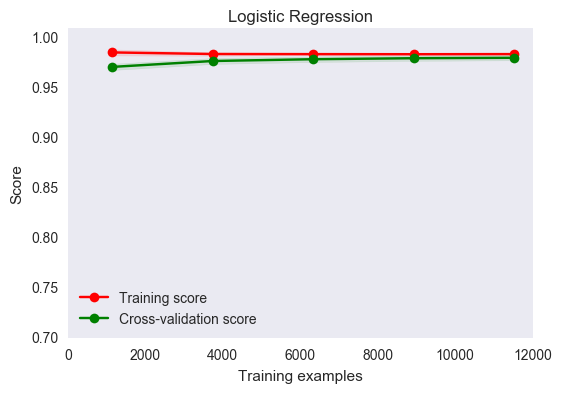

In [103]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(LogisticRegression(), 'Logistic Regression', X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [104]:
pr, rec, fsc, sup = precision_recall_fscore_support(y_test, y_pred, average=None)
print(pr)
print(rec)

[ 0.98847835  0.91483516]
[ 0.98769353  0.9198895 ]


We see that after removing WLK data from this set, the predictive power of this model is greatly imporoved. With precisions and recalls >90% for both classes of avatars and no apparent overfitting, we conclude that this model should do a decent job at predicting whether or not an avatar will reach max level given some time-series observations. The above analysis indicates that each expansion era needs to be treated completely separately in order to make a strong model.

# Conclusions
We found that this model with many (~500) features can do a good job at predicting whether or not an avatar reaches max level. Essentially, this provides a way to accurately predict whether or not an avatar will reach max level based upon the locations it visits, the guilds it occupies, its race and class, and play behavior. The accuracy, precision, and recall of this model are all >90%. In terms of real-world applicability, such a model could potentially be used to track individual avatars and estimate whether or not they will be played to max level. Developers could then trace these avatars to individual players and use this information to better understand why some players might stop playing (e.g. stop max leveling?). 